In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install http://sourceforge.net/projects/matplotlib/files/matplotlib-toolkits/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759600 sha256=c774ed9848867169779d2cc200c422f908bda86b2d844bcdf8b87b8d88662eef
  Stored in directory: /tmp/pip-ephem-wheel-cache-fsbd794x/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
     |████████████████████████████████| 256kB 343kB/s 
  ERROR: Cannot unpack file /tmp/pip-unpack-3j7e90t1/matplotlib-toolkits (downloaded 

In [3]:
!pip install netcdf4
!pip install pyMCR
!pip install geopandas

     |████████████████████████████████| 921kB 14.5MB/s 
  Created wheel for pyMCR: filename=pyMCR-0.3.2-cp37-none-any.whl size=26497 sha256=1963f845c86ca3e87ab64084200b30cc4e665b0ab9202b43aa96a2d74ddb5178
  Stored in directory: /root/.cache/pip/wheels/bf/61/c2/59ca0fb0ad90a9f608586e960a20e03449982e39d88ab2be2f
Successfully built pyMCR
     |████████████████████████████████| 1.0MB 15.3MB/s 
     |████████████████████████████████| 15.4MB 296kB/s 


# Libraries

In [4]:
#!/bin/env python
import sys
import glob
import os
import re
import numpy as np
import numpy.ma as ma
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
import torch
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import measure, transform
#from skimage.segmentation import slic
#from skimage.segmentation import mark_boundaries
from skimage import io
from skimage import data, segmentation, color
from scipy.ndimage import label, generate_binary_structure
from scipy.spatial import distance
from scipy import ndimage
from shapely.geometry import Point, LineString, Polygon, LinearRing, MultiPoint
from descartes import PolygonPatch
import networkx as nx
import tarfile
import string
import calendar
import cv2
import random
from google.colab.patches import cv2_imshow
from mpl_toolkits.basemap import Basemap,cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4
from geopandas import GeoSeries
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics import confusion_matrix, accuracy_score



In [5]:
DIR_DATA = '/content/drive/MyDrive/StageUParis/DATA/H2O/'
DIR_TRAIN = '/content/drive/MyDrive/StageUParis/DATA/LABELS/'
DIR_TEST = '/content/drive/MyDrive/StageUParis/Test/'

# Class **SplitImageLevels**

In [6]:
class SplitImageLevels():  
  image_type = "LT"
  year = 2008
  month = 5
  day = 1

  degree = 0.625
  pixel_size = 0.3125
  vmax = 35
  vmin = 0

  weight_gray_values = 1
  N_CLUSTERS = 2

  images = list()

  def __init__ (self,DIR_DATA=DIR_DATA, DIR_TRAIN=DIR_TRAIN):
    self.DIR_DATA = DIR_DATA
    self.DIR_TRAIN = DIR_TRAIN





  ############################################################################
  ####                      GETTERS AND SETTERS
  ############################################################################

  def set_DIR_DATA (self, DIR_DATA):
    self.DIR_DATA = DIR_DATA

  def get_DIR_DATA (self):
    return self.DIR_DATA

  def set_DIR_TRAIN (self, DIR_TRAIN):
    self.DIR_TRAIN = DIR_TRAIN
  
  def get_DIR_TRAIN (self):
    return self.DIR_TRAIN

  def set_DIR_TEST (self, DIR_TEST):
    self.DIR_TEST = DIR_TEST

  def get_DIR_TEST (self):
    return self.DIR_TEST

  def set_year(self,year):
    self.year = year

  def get_year(self):
    return self.year
  
  def set_month(self,month):
    self.month = month
  
  def get_month(self):
    return self.month

  def set_day(self,day):
    self.day = day

  def get_day(self):
    return self.day

  def set_image_type(self,image_type):
    self.image_type = image_type

  def get_image_type(self):
    return self.image_type

  def set_image_name(self,image_name):
    self.image_name = image_name

  def get_image_name(self):
    return self.image_name

  def set_pixel_size(self, degree, size):
    self.degree = degree
    self.pixel_size = size

  def set_region_area(self, max_area, min_area):
    self.max_area = max_area
    self.min_area = min_area

  def set_weight_gray_values(self, weight_gray_values):
    self.weight_gray_values = weight_gray_values

  def set_cluster_value (self, N_CLUSTERS):
    self.N_CLUSTERS = N_CLUSTERS

  def get_cluster_value(self):
    return self.N_CLUSTERS






  ############################################################################
  ####                        READ THE DATA
  ############################################################################

  def get_image_by_leves (self):
    #for index, layer in enumerate(np.arange(self.start, self.end, self.steps)):
    index = 0
    
    lat_g = np.arange(20.,50.,self.degree)
    lon_g = np.arange(100.,150.,self.degree)

    #initialization
    self.colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

    for year in range(self.year, self.year + 1):
      for month in range(self.month, self.month + 1):
        for day in range(self.day, self.day + 1):

          fname = self.DIR_DATA + 'IASIdaily_' + str(year) + '%02d'%month+'%02d'%day+'.nc'
          self.image_name = self.image_type + '-level-' + str(year) + '%02d'%month+'%02d'%day+'.png'

          print('reading info ...')

          if not(os.path.isfile(fname)):
            continue

          nc = netCDF4.Dataset(fname)
          flag = nc.variables['flag'][:]
          mask1 = (flag == 0) # Without clouds
          
          lat = nc.variables['lat'][mask1]
          lon = nc.variables['lon'][mask1]
          col = nc.variables[self.image_type][mask1]
          nc.close()

          mask2 = (np.isnan(col) == False) 

          # gridding the data
          for ilat in range(lat_g.shape[0]):
            for ilon in range(lon_g.shape[0]):
              # Grille régulier
              # 25 km
              # 0 25 degrée lattitude et longitude

              # Grille regulier of 0.125 degree
              maskgrid = (lat[:] >= (lat_g[ilat] - self.pixel_size)) & (lat[:] < (lat_g[ilat] + self.pixel_size)) & (lon[:] >= (lon_g[ilon] - self.pixel_size)) & (lon[:] < (lon_g[ilon] + self.pixel_size))
              
              # Defining invalid data
              mask = mask2 & maskgrid

              if len(col[mask]) != 0:
                median = np.mean(col[mask])
                #if median >= layer:
                self.colgrid[ilat,ilon] = median

          print('data readed correctly')

          # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
          self.colgrid1 = ma.masked_values(self.colgrid, 0.)

          self.v_x, self.v_y = np.meshgrid(lon_g, lat_g)
          gradx, grady = np.gradient(self.colgrid, edge_order=1)

          fig, (ax1) = plt.subplots(1, 1, figsize = (11,8))
          ax1.pcolormesh(self.v_x, self.v_y, self.colgrid, shading='nearest',cmap='gray', vmin=self.vmin, vmax=self.vmax)
          ax1.axis('off')
          fig.savefig(self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig)


          fig2, (ax2) = plt.subplots(1, 1, figsize = (11,8))
          ax2.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=self.vmin, vmax=self.vmax)
          ax2.axis('off')
          fig2.savefig("color-" + self.image_name, bbox_inches='tight', pad_inches=0)
          plt.close(fig2)








  ###############################################################
  ###             LOAD IMAGE INFORMATION
  ###############################################################

  def load_image_from_files (self, filename):
    img_bgr = io.imread(filename) 
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    return img_bgr, gray



  def process_set_images(self, image, image_color):
    image, _, background = self.filter_image(image)
    regions, _ = self.get_mser_regions(image)
    
    regx, regy, polys, lines, values = self.set_mser_regions(image, background, regions[:])
    #self.divide_regions(image,regx, regy, polys, lines, values)
    labels, centers = self.classify_neighbors(image, regx, regy,polys, values)
    self.plot_mser_final_regions(image, regx, regy, values)
    
    #self.show_mser_red_regions(image, regions[:], labels)
    #polys = self.classify_regions(image,poly[:])
    #polys = self.classify_all_regions(image, poly[:])
    #self.plot_mser_regions_3d(regx, regy, values, labels)
    







  ###############################################################
  ###             TRAITEMENT
  ###############################################################

  def get_pollution_image_reference(self, image):

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Search Pollution:
    reds_colors = np.array([255,0,0], dtype=np.uint8)
    #high_reds_colors = np.array([130, 255, 255], dtype=np.uint8)

    # Search Mix:
    low_blues_colors = np.array([100,65,75], dtype=np.uint8)
    high_blues_colors = np.array([130, 255, 255], dtype=np.uint8)
    
    pollution_mask = cv2.inRange(image_hsv, reds_colors, reds_colors)

    print("pollution mask", pollution_mask)
    
    # Momentos
    #moments = cv2.moments(mascara_azul)
    #area = int(moments['m00'])
    #print("Pixeles activos "+str(area) +" pixeles")


  def resize_image_percentage (self, image, scale_percent = 100):
    ### SCALE
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    return image

  def normalize_image(self, image):
    return cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , 0, 255, cv2.NORM_MINMAX )

  def pretraitement_image(self, image, kernel_size = 9, iterations=3):
    ### MORPHO FILTERS
    kernel = np.ones((kernel_size,kernel_size),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations = iterations)

    return image

  ## REMOVING THE HOLES
  def masking_interest_region(self, image):
    # Take the holes (pixels value = 0) and set it as 255
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    image = np.where(image == 0, 255, image) 
    image = np.where(image != 255, 0, image) # This is the mask of the background
    image_holes_dilate = cv2.morphologyEx(image, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 3)
    image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground

    return image_holes_dilate, image_holes_dilate_inv

  def find_edges (self, image):
    ## Below code convert image gradient in both x and y direction
    image = cv2.Laplacian(image, cv2.CV_64F, ksize=3) 
    image = np.uint8(np.absolute(image))
    #image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

    return image


  def filter_image (self, image):
    image = self.resize_image_percentage(image, 100)
    image = self.pretraitement_image(image,6,3)
    background, foreground = self.masking_interest_region(image)
    
    return image, foreground, background

  def get_mser_regions(self, image, vmin=300,vmax=50000):
    mser = cv2.MSER_create(1, vmin, vmax, .25, 1., 1000, 1.001, 0.003, 5)
    #(1, 100, 20000, .25, 1., 1000, 1.001, 0.003, 5)
   
    #fig, ax = plt.subplots(1,1)
    #colorinfo = ax.imshow(image, cmap='gray')
    #fig.colorbar(colorinfo)

    regions, bboxes = mser.detectRegions(image)
    regions = sorted(regions, key=cv2.contourArea, reverse=True)

    return regions, bboxes







  ###############################################################
  ###             PLOTTING
  ###############################################################

  def show_mser_red_regions(self, image, regions, labels):
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    #colors = np.array([(255,0,0),[(0,255,0),(0,0,255),(0,255,255),(255,255,0),(100,0,100),(24,180,0)])
    colors = list([(255,0,0),(0,255,0),(0,0,255),(0,255,255),(255,255,0),(100,0,100),(24,180,0)])

    #for i in labels:
    #  print(colors[i])

    #for l in labels:
    for i, p in enumerate(regions[:]):
      if i == (len(regions[:3]) - 1):
        color = (255,0,0)
      elif i == (len(regions[:3]) - 2):
        color = (0,0,255)
      else:
        color = (0,255,0)

      #print("color", color, "for", i)
      for k in p:
        cv2.circle(image, (k[0],k[1]), radius=0, color=color, thickness=-1)

    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    #ax.invert_yaxis()












  def set_mser_regions(self, image, background, regions):
    regsX = list()
    regsY = list()
    regsPoly = list()
    regsLine = list()
    values_gray = list()

    for j,r in enumerate(regions):
      region = list()
      hull = cv2.convexHull(r)

      for h in hull:
          region.append(h[0].tolist())

      region.append(region[0])
      poly = Polygon(region)
      line = LineString(region)
      value_pixel = self.get_region_value(image,poly)

      if np.isnan(value_pixel):
        print(value_pixel)
        break
      #xs = [pnt[0] if background[pnt[1],pnt[0]] != 255 else np.nan for pnt in r[:]]
      #ys = [pnt[1] if background[pnt[1],pnt[0]] != 255 else np.nan for pnt in r[:]]
      xs = [pnt[0] for pnt in r]
      ys = [pnt[1] for pnt in r]

      regsX.append(xs)
      regsY.append(ys)
      regsPoly.append(poly)
      regsLine.append(line)
      values_gray.append(value_pixel)

    return regsX, regsY, regsPoly, regsLine, values_gray

  def export_current_region (self, image, regsX, regsY, filename="image-temp.png"):
    x_range = [0, image.shape[1]]
    y_range = [0, image.shape[0]]

    fig, ax1 = plt.subplots(1, 1, figsize=(11,8))
    ax1.scatter(regsX,regsY, cmap="gray")
    ax1.set_xlim(*x_range)
    ax1.set_ylim(*y_range)
    ax1.invert_yaxis()
    ax1.axis('off')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

  def slic_regions(self,image,mask,compactness=50,n_segments=150):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # compactness=compactness,
    labels_1 = segmentation.slic(image,n_segments=n_segments)
    out_1 = color.label2rgb(labels_1, image, kind='avg', bg_label=0)
    out_1 = cv2.cvtColor(out_1, cv2.COLOR_RGB2GRAY)
    out_1 = cv2.bitwise_and(out_1,out_1,mask=mask)

    fig, ax = plt.subplots(1, 1)
    ax.imshow(out_1, cmap="gray")
    ax.set_title("SLIC")

    return out_1
    

  def divide_regions(self, image, regx, regy, polys, lines, values):
    xx_range = [0, image.shape[1]]
    yy_range = [0, image.shape[0]]

    areas = list()
    for p in polys:
      areas.append(p.area)

    x_range = [100, 150, 10]
    y_range = [20, 48, 5]

    fig, ax = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    fig0, ax0 = plt.subplots(1,1)
    fig3, ax3 = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)
    for i,line in enumerate(lines):
      area = polys[i].area
      mean_areas = np.mean(areas)
      if area > mean_areas and area > 30000.:
        mean_value = np.mean(values)
        if values[i] > mean_value:
          x, y = line.xy
          filename = "image-temp-"+ str(i) +".png"
          self.export_current_region(image, regx[i] ,regy[i], filename )
          im, im_gray = self.load_image_from_files(filename)
          im_gray = cv2.bitwise_not(im_gray)

          # SLIC
          img_slic = self.slic_regions(image,im_gray)

          img_temp = img_slic.copy()
          img_temp = cv2.cvtColor(img_temp, cv2.COLOR_GRAY2RGB)

          # MSER
          reg2, _ = self.get_mser_regions(img_temp,100,20000)
          #mser = cv2.MSER_create(1, 100, 20000, .25, 1., 1000, 1.001, 0.003, 5)
          #reg2, _ = mser.detectRegions(img_temp)
          #reg2 = sorted(reg2, key=cv2.contourArea, reverse=True)

          #for p in reg2[:]:
          #  for k in p:
          #    cv2.circle(img_temp, (k[0],k[1]), radius=0, color=(0, 0, 255), thickness=-1)
          #ax3.imshow(img_temp)

          # PLOT
          rx, ry, ps, ls, vs = self.set_mser_regions(image, background, reg2)
          
          #self.plot_mser_final_regions(image, rx, ry, vs)
          # OLD REGIONS
          rgsX_2 = list()
          rgsY_2 = list()

          for reg in regx:
            line = list()
            for j in reg:
              line.append((j / (image.shape[1] / 50)) + 100)
            rgsX_2.append(line)

          for reg in regy:
            line = list()
            for j in reg:
              line.append(((image.shape[0] - j) / (image.shape[0] / 28)) + 20)
            rgsY_2.append(line)
          
          if self.image_type == 'LT':
            max_color_value = 35
          else:
            max_color_value = 45
          
          colors = sns.color_palette("YlOrBr", max_color_value + 1)
          cmap_old = matplotlib.colors.ListedColormap(colors)
          norm_old = matplotlib.colors.BoundaryNorm(np.arange(max_color_value + 1) - 0.5, cmap_old.N)

          #for j,val in enumerate(values):
          ax3.scatter(rgsX_2[i], rgsY_2[i], marker='.', color=cmap_old(norm_old(int(values[i]))) )
          ax3.set_xlim(*x_range)
          ax3.set_ylim(*y_range)
          ax3.set_title('OLD Regions - IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))

          sm_old = matplotlib.cm.ScalarMappable(cmap=cmap_old, norm=norm_old)
          cbar_ax_old = fig.add_axes([0.09, 0.06, 0.84, 0.02])
          cb_old = fig3.colorbar(sm_old,cax=cbar_ax_old,orientation='horizontal')
          if self.image_type == 'LT':
            cb_old.set_ticklabels(np.arange(0,35,4))
          else:
            cb_old.set_ticklabels(np.arange(0,45,5))
          cb_old.set_label('DU')

          # NEW
          ax0.plot(x, y, label="area:" + str(int(area)))
          ax0.set_xlim(*xx_range)
          ax0.set_ylim(*yy_range)
          ax0.invert_yaxis()

          rgsX2 = list()
          rgsY2 = list()

          for reg in rx:
            line = list()
            for i in reg:
              line.append((i / (image.shape[1] / 50)) + 100)
            rgsX2.append(line)

          for reg in ry:
            line = list()
            for i in reg:
              line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
            rgsY2.append(line)
          
          if self.image_type == 'LT':
            max_color_value = 35
          else:
            max_color_value = 45
          
          colors = sns.color_palette("YlOrBr", max_color_value + 1)
          cmap = matplotlib.colors.ListedColormap(colors)
          norm = matplotlib.colors.BoundaryNorm(np.arange(max_color_value + 1) - 0.5, cmap.N)

          for i,val in enumerate(vs):
            ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
            ax.set_xlim(*x_range)
            ax.set_ylim(*y_range)
            ax.set_title('Max Regs - IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))

          sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
          cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
          cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')
          if self.image_type == 'LT':
            cb.set_ticklabels(np.arange(0,35,4))
          else:
            cb.set_ticklabels(np.arange(0,45,5))
          cb.set_label('DU')

    fig0.legend()
    

    

  
  

  def classify_neighbors(self, image, regsX, regsY, polygons, values):
    #ca = np.zeros([len(polygons),len(polygons), len(values)], np.uint16)
    coordinatesList = list()

    # Ploting weights
    w_coords_x = list()
    w_coords_y = list()
    w_grays = list()

    # Normalization for gray values (Pollution)
    valuesNorm = (values - min(values)) / (max(values) - min(values))

    for i,value in enumerate(valuesNorm):
      # Normalization for X and Y
      coord_x = polygons[i].centroid.x / image.shape[1]
      coord_y = polygons[i].centroid.y / image.shape[0]
      gray_value = value * self.weight_gray_values

      ## To apply kmeans
      coordinatesList.append(np.array([coord_x,coord_y, gray_value]))
      
    coordinatesArray = np.asarray(coordinatesList)

    ## To plot weights
    for coord in coordinatesArray:
      w_coords_x.append(coord[0])
      w_coords_y.append(coord[1])
      w_grays.append(coord[2])

    fig_, ax0 = plt.subplots(1,1)
    number_regions = np.arange(len(coordinatesArray))

    w_legends = ["X","Y","Gray"]
    ax0.scatter(number_regions, w_coords_x, label=w_legends[0])
    ax0.scatter(number_regions, w_coords_y, label=w_legends[1])
    ax0.scatter(number_regions, w_grays, label=w_legends[2])
    ax0.set_title("Weights comparison")
    ax0.set_xlabel("Number of Regions")
    ax0.set_ylabel("Weight")
    hand, labl = ax0.get_legend_handles_labels()
    plt.legend()

    # TESTING KMEANS
    wcss = list()
    for i in range(1,50):
      kmeanstest = KMeans(n_clusters=i, random_state=0).fit(coordinatesArray)
      wcss.append(kmeanstest.inertia_)
      
    fig0, ax = plt.subplots(1,1)
    ax.scatter(self.N_CLUSTERS,wcss[self.N_CLUSTERS], c='red', label="Selected cluster")
    ax.plot( np.arange(len(wcss)) , wcss)
    ax.set_title("Optimal number of clusters")
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Inertia")
    fig0.legend()

    clustering = KMeans(n_clusters=self.N_CLUSTERS, max_iter=300).fit(coordinatesArray)

    x_range = [100, 150, 10]
    y_range = [20, 48, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
      rgsY2.append(line)

    fig, ax1 = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)
    
    #print("labels", clustering.labels_)
    #print("center", clustering.cluster_centers_)

    # hls
    # Greys
    colors = sns.color_palette("hls", max(clustering.labels_) + 1)

    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(max(clustering.labels_) + 1) - 0.5, cmap.N)
 
    for i,label in enumerate(clustering.labels_):
      ax1.scatter(rgsX2[i],rgsY2[i], marker='.', color=cmap(norm(label)) ) 
      ax1.set_xlim(*x_range)
      ax1.set_ylim(*y_range)
      ax1.set_title('CLUSTERS - IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year) + " - # Clusters: " + str(self.N_CLUSTERS) )

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
    cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')
    cb.set_ticklabels(np.arange(1,self.N_CLUSTERS))
    cb.set_ticks(np.arange(self.N_CLUSTERS), update_ticks=True)
    cb.set_label('Clusters')

    return clustering.labels_ , clustering.cluster_centers_




    
  def classify_regions(self, image, polygons):
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )

    temp_polygons = polygons.copy()
    first_poly = temp_polygons[0]

    for i,poly in enumerate(temp_polygons[:]): 
      if poly is None:
        continue 

      #for j,ut in enumerate(ut_polys[:]):
      if first_poly.intersects(poly):
        percentage = (first_poly.intersection(poly).area/first_poly.area) * 100

        if percentage > 85:
          value_poly_1 =  self.get_region_value(image, first_poly)
          value_poly_n =  self.get_region_value(image, poly)
          if np.abs(value_poly_1 - value_poly_n) < 5:
            temp_polygons[i] = None

    return temp_polygons



  def classify_all_regions(self, image, polygons):
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )
    
    temp_polygons = polygons.copy()
    #first_poly = temp_polygons[0]

    for i, poly in enumerate(temp_polygons[:]): 
      if poly is None:
        continue 
      
      if i == 0:
        first_poly = temp_polygons[0]
      #else:
      #  first_poly = poly

      if first_poly.intersects(poly):
        percentage = (first_poly.intersection(poly).area / first_poly.area) * 100

        if percentage > 85:
          value_poly_1 =  self.get_region_value(image, first_poly)
          value_poly_n =  self.get_region_value(image, poly)

          if np.abs(value_poly_1 - value_poly_n) < 5:
            temp_polygons[i] = None

    return temp_polygons


  def get_region_value(self, image, polygon):
    """
    This function returns the mean pixel value from a given polygon
    """
    image = cv2.normalize(image, np.ones((image.shape[0], image.shape[0])) , self.vmin, self.vmax, cv2.NORM_MINMAX )

    minx, miny, maxx, maxy = polygon.bounds #Boite englobante

    pixel_steps_x = image.shape[1] * self.degree / self.colgrid.shape[1]
    pixel_steps_y = image.shape[0] * self.degree / self.colgrid.shape[0]

    longs = np.arange(minx, maxx, pixel_steps_x)
    lats = np.arange(miny, maxy, pixel_steps_y)

    set_of_coordinates = list()
    for lon in longs:
      for lat in lats:
        if np.isnan(lat):
          print("lat is nan")
        if np.isnan(lon):
          print("lon is nan")

        if image[int(lat), int(lon)] > 0:
          set_of_coordinates.append(image[int(lat), int(lon)])

    value_pixel = np.mean(set_of_coordinates)

    if np.isnan(value_pixel):
      value_pixel = 1.
    
    return value_pixel


  def export_mser_regions (self,image,regsX,regsY,values, filename="regions-mser.png"):
    x_range = [0, image.shape[1]]
    y_range = [0, image.shape[0]]

    fig, ax = plt.subplots(1,1, figsize=(11,8), facecolor=(0, 0, 0))
    

    if self.image_type == 'LT':
      max_color_value = 35
    else:
      max_color_value = 45
    
    colors = sns.color_palette("Greys_r", max_color_value + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(max_color_value + 1) - 0.5, cmap.N)

    for i,val in enumerate(values):
      ax.scatter(regsX[i], regsY[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.invert_yaxis()
      ax.axis('off')

    matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.savefig(filename, bbox_inches='tight', pad_inches=0,transparent=True)
    plt.close(fig)

    return filename



  def plot_mser_final_regions (self, image, regsX, regsY, values):

    x_range = [100, 150, 10]
    y_range = [20, 48, 5]

    rgsX2 = list()
    rgsY2 = list()

    for reg in regsX:
      line = list()
      for i in reg:
        line.append((i / (image.shape[1] / 50)) + 100)
      rgsX2.append(line)

    for reg in regsY:
      line = list()
      for i in reg:
        line.append(((image.shape[0] - i) / (image.shape[0] / 28)) + 20)
      rgsY2.append(line)

    fig, ax = plt.subplots(1,1)
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    if self.image_type == 'LT':
      max_color_value = 35
    else:
      max_color_value = 45
    
    colors = sns.color_palette("YlOrBr_r", max_color_value + 1)
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(np.arange(max_color_value + 1) - 0.5, cmap.N)

    for i,val in enumerate(values):
      ax.scatter(rgsX2[i], rgsY2[i], marker='.', color=cmap(norm(int(val))) )
      ax.set_xlim(*x_range)
      ax.set_ylim(*y_range)
      ax.set_title('REGIONS ' + str(len(values)) + ' - IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar_ax = fig.add_axes([0.09, 0.06, 0.84, 0.02])
    cb = fig.colorbar(sm,cax=cbar_ax,orientation='horizontal')

    if self.image_type == 'LT':
      cb.set_ticklabels(np.arange(0,35,4))
    else:
      cb.set_ticklabels(np.arange(0,45,5))

    cb.set_label('DU')


  def plot_mser_regions_3d(self, regsX, regsY, values, labels):
    
    f3d = plt.figure(figsize=(14, 9))
    ax2 = plt.axes(projection ='3d')

    #colors = np.array(["yellow","blue","red","green","magenta","cyan","gray"])
    #colors = {0:"yellow", 1:"blue", 2:"red", 3: "green", 4: "magenta", 5: "cyan", 6:"gray"}
    #print("values", values)
    #print("labels", clustering.labels_)
    #print("center", clustering.cluster_centers_)
    
    for i,label in enumerate(labels):

      if label == 0:
        color = "red"
      elif label == 1:
        color = "yellow"
      elif label == 2:
        color = "green"
      elif label == 3:
        color = "magenta"
      elif label == 4:
        color = "cyan"
      elif label == 5:
        color = "gray"
      elif label == 6:
        color = "olive"
      else:
        color = "black"

      ax2.scatter(regsX[i], regsY[i], values[i], marker='.', c=color) # c=colors[clustering.labels_]       #,label='Region ' + str(i))
      ax2.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))
      



  def show_image(self, image):
    fig, ax = plt.subplots(1,1, figsize=(11,8))
    ax.imshow(image, cmap='gray')

  def plot_original_image(self):

    if self.image_type == 'LT':
      vmax = 35
      vmin = 3
    else:
      vmax = 45
      vmin = 5

    fig, ax1 = plt.subplots(1,1)
    
    m=Basemap(llcrnrlon=100.,llcrnrlat=20.,urcrnrlon=150.,urcrnrlat=48.,resolution='i')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawmeridians(np.r_[100:151:10], labels=[0,0,0,1], color='grey',fontsize=8,linewidth=0)
    m.drawparallels(np.r_[20:48:5], labels=[1,0,0,0], color='grey',fontsize=8,linewidth=0)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='1%', pad=0.05)
    cs = ax1.pcolormesh(self.v_x, self.v_y, self.colgrid1, shading='nearest',cmap='jet', vmin=vmin, vmax=vmax)
    ax1.set_title('IASI ' + self.image_type + " - " + str(self.day) +"/"+ str(self.month) +"/"+ str(self.year))
    fig.colorbar(cs,cax=cax)
    

  ###############################################################
  ###             REMOVE TEMP FILES
  ###############################################################

  def remove_temporal_files(self):
    try:
      os.remove(self.image_name)
      #Raising your own errors
      raise ErrorType("Deleting")
    except ErrorType as e:
      print("Error deleting the file -> ", self.image_name)
    

In [7]:
imageLT = SplitImageLevels()

imageLT.set_year(2008)
imageLT.set_month(5)
imageLT.set_day(6)
imageLT.set_image_type("LT")
imageLT.set_image_name("levels")
imageLT.set_weight_gray_values(1)
imageLT.set_cluster_value(30)
imageLT.set_pixel_size(0.25,.125)

imageLT.get_image_by_leves()

reading info ...
data readed correctly


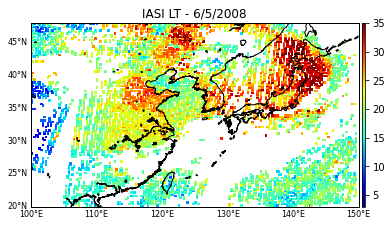

In [8]:
imageLT.plot_original_image()

In [9]:

# imageLT.get_image_name()
bgr , gray = imageLT.load_image_from_files(imageLT.get_image_name())
#imageLT.process_set_images(gray,bgr)
#imageLT.remove_temporal_files()
#imageLT.plot_original_image()


255 36


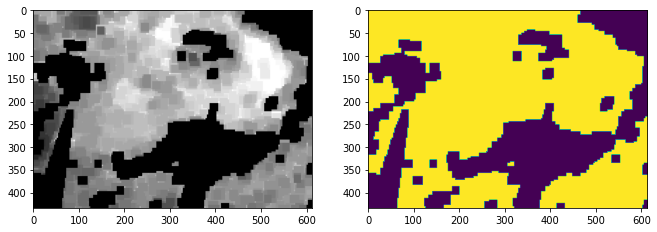

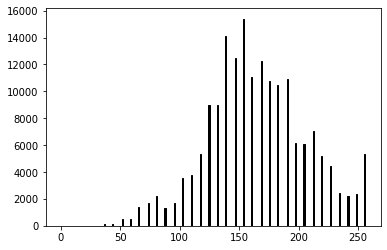

In [10]:
image, foreground, background = imageLT.filter_image(gray)

kernel = np.ones((3,3),np.uint8)
foreground = cv2.dilate(foreground,kernel,iterations = 3)
image1 = cv2.bitwise_and(image,image, mask=foreground)
image2 = cv2.bitwise_and(image,image, mask=background)

myimage = cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB)
myimage = cv2.bitwise_and(myimage,myimage, mask=foreground)
#t_i = cv2.normalize(image1, None, 0, 255, cv2.NORM_MINMAX )
t_i = ma.masked_values(image1, 0.)
#print(t_i[~t_i.mask])
#mymask = t_i.mask
#image3 = cv2.bitwise_and(image, image, mask=mymask)

print(t_i.max(), t_i.min())

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(11,8))
ax0.imshow(myimage)
ax1.imshow(foreground)
#fig.title('Morpho Operations - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))

#ax1.imshow(background, cmap="gray")
#ax2.imshow(image2)
#ax3.imshow(foreground, cmap="gray")

fig3, ax3 = plt.subplots(1,1)
#ax3.hist(t_i.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
ax3.hist(t_i[~t_i.mask],256,[0,256], fc='k', ec='k')
#ax3.hist(image1.ravel(),254,[1,256], fc='k', ec='k')
fig3.show()

857


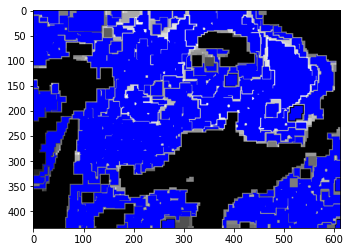

In [11]:
"""
delta	          it compares (sizei−sizei−delta)/sizei−delta
min_area	      prune the area which smaller than minArea
max_area	      prune the area which bigger than maxArea
max_variation	  prune the area have similar size to its children
min_diversity	  for color image, trace back to cut off mser with diversity less than min_diversity
max_evolution	  for color image, the evolution steps
area_threshold	for color image, the area threshold to cause re-initialize
min_margin	    for color image, ignore too small margin
edge_blur_size	for color image, the aperture size for edge blur
"""

mser = cv2.MSER_create( 1, # delta 
                       100, # min_area
                       34400, #max_area 
                       4., # max_variation 
                       .01, # min_diversity 
                       10000, # max_evolution 
                       1.04, # area_threshold 
                       0.003, # min_margin
                       5) # edge_blur_size

# (1, 100, 20000, .25, 1., 1000, 1.001, 0.003, 5)
regions, bboxes = mser.detectRegions(myimage)
regions = sorted(regions, key=cv2.contourArea, reverse=True)

#regions, bboxes = imageLT.get_mser_regions(image1, 100, 30000)
#print(image1.shape)
print(len(regions))

img_mser = cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB)

for p in regions[:]:
  for k in p:
    cv2.circle(img_mser, (k[0],k[1]), radius=0, color=(0, 0, 255), thickness=-1)
plt.imshow(img_mser)

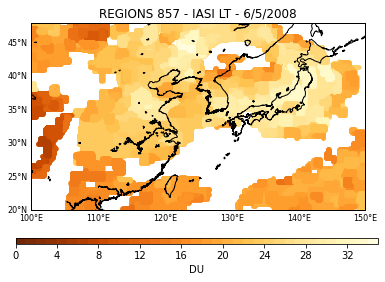

In [12]:
kernel = np.ones((6,6), np.uint8)
background  = cv2.morphologyEx(background, cv2.MORPH_DILATE, kernel)
regx, regy, polys, lines, values = imageLT.set_mser_regions(t_i, background, regions[:])
imageLT.plot_mser_final_regions(t_i, regx, regy, values)

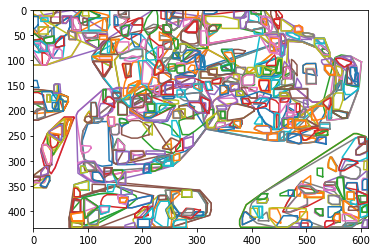

In [13]:
fig, ax = plt.subplots(1,1)
xx_range = [0, image.shape[1]]
yy_range = [0, image.shape[0]]

for j,poly in enumerate(polys[:]):
  xxx,yyy = poly.exterior.xy

  ax.plot(xxx,yyy)
  ax.set_xlim(*xx_range)
  ax.set_ylim(*yy_range)
  ax.invert_yaxis()

In [14]:
filename = imageLT.export_mser_regions(image, regx, regy, values)
image_flat = io.imread(filename)
image_color = image_flat.copy()
image_flat = cv2.cvtColor(image_flat, cv2.COLOR_RGBA2GRAY)
image_flat = np.where(image_flat == 255, 0, image_flat) 
#image_flat = np.where(image_flat == 255, 254, image_flat)

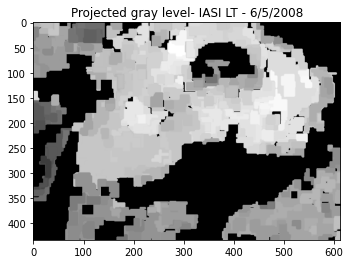

In [15]:
f1, ax1 = plt.subplots(1,1)
xx_range = [0, image.shape[1]]
yy_range = [0, image.shape[0]]

#for p in polys:
#  x,y = p.exterior.xy

#  ax1.plot(x,y)
#  ax1.set_xlim(*xx_range)
#  ax1.set_ylim(*yy_range)
#  ax1.invert_yaxis()

ax1.imshow(image_flat, cmap="gray")
ax1.set_title('Projected gray level- IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
f1.show()


components = [1..8]
for val in components:


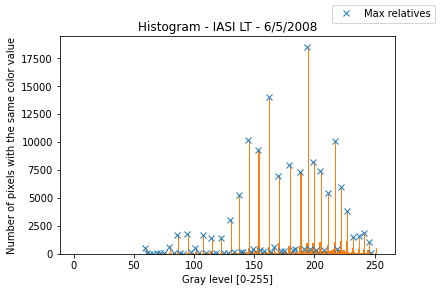

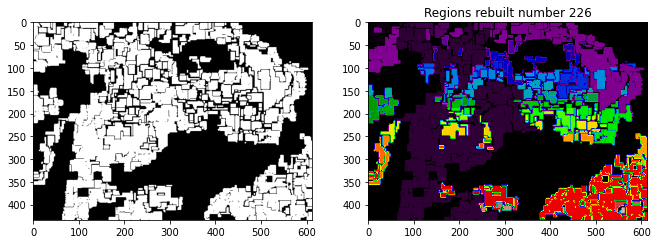

In [67]:
# Make bins
bins = np.arange(image_flat.min() + 1, 254)
# Compute histogram
h, _ = np.histogram(image_flat, bins)
bins = bins[:len(bins) - 1]

peaks, _ = find_peaks(h) #,height=1000)

# Main condition to create the threshold
gray_levels_selected = bins[peaks]
black_image = np.zeros(image_flat.shape, np.uint8)

for i, value in enumerate(gray_levels_selected):
  #black_image[image_flat == value] = 1
  black_image = np.where(image_flat == value, 1, black_image)
  #black_image  = cv2.morphologyEx(black_image, cv2.MORPH_ERODE, np.ones((3,3), np.uint8))

kernel = np.ones((3,3), np.uint8)
black_image  = cv2.morphologyEx(black_image, cv2.MORPH_OPEN, kernel)
#black_image  = cv2.morphologyEx(black_image, cv2.MORPH_ERODE, np.ones((2,2), np.uint8))

labels_partition, num = measure.label(black_image, return_num=True, background=0.) 
#s = generate_binary_structure(2,2)
#_labels = ndimage.label(black_image, structure=s)
#labels_partition = _labels[0]
#num = _labels[1]

f2,ax2 = plt.subplots(1,1)
ax2.plot(peaks,h[peaks], "x", label="Max relatives")
ax2.hist(image_flat.ravel(),254,[1,254]);
ax2.set_title('Histogram - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax2.set_xlabel("Gray level [0-255]")
ax2.set_ylabel("Number of pixels with the same color value")
f2.legend()
f2.show()

fig0, (ax0,ax1) = plt.subplots(1,2, figsize=(11,8))
ax0.imshow(black_image, cmap="gray")
ax1.imshow(labels_partition, cmap='nipy_spectral')
ax1.set_title("Regions rebuilt number " + str(num))
fig0.show()

In [68]:
#_labels = ndimage.label(black_image)
#num_regions = _labels[1]

valuesNorm = (values - min(values)) / (max(values) - min(values))

# Center of mass of each region
centers = ndimage.measurements.center_of_mass(black_image, labels_partition, np.arange(1,num))
print(len(centers), len(valuesNorm), num)
print(centers)

225 857 226
[(33.09641434262948, 13.140239043824701), (10.306324110671937, 35.21146245059288), (6.188679245283019, 40.58490566037736), (3.8, 71.1), (231.9647801749039, 187.04629574294307), (5.0, 96.0), (8.69329073482428, 125.89936102236422), (15.4316807738815, 160.05199516324063), (8.635294117647058, 235.75882352941176), (6.986666666666666, 258.46), (12.511290322580646, 286.9225806451613), (2.76027397260274, 323.1095890410959), (21.66144975288303, 378.28857770455795), (4.0, 409.0), (3.0, 422.5), (107.84035056017348, 523.4868088182146), (16.571428571428573, 57.214285714285715), (17.194444444444443, 20.86111111111111), (22.70027247956403, 194.54768392370573), (71.2414975707345, 34.83423835381537), (28.29824561403509, 131.0701754385965), (24.5, 269.0), (33.65470852017937, 293.4865470852018), (30.844827586206897, 311.7931034482759), (35.593939393939394, 329.1757575757576), (39.45289855072464, 168.8586956521739), (34.0, 450.0), (39.836363636363636, 441.4909090909091), (54.86501377410468, 31

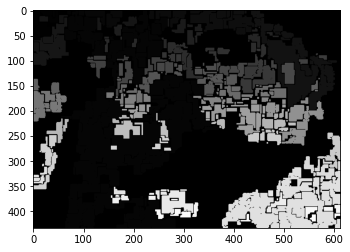

In [69]:
tmp = np.zeros(labels_partition.shape, np.uint8)
for i in range(num):
  tmp = np.where(labels_partition == i, i, tmp)
  #MultiPoint(tmp)
plt.imshow(tmp, cmap="gray")

In [70]:
## CODIGO PARA CREAR PARTICION DE REGIONES COMO POLIGONOS
## PRIMERO ENCONTRAR BORDES
## LUEGO REGIONES

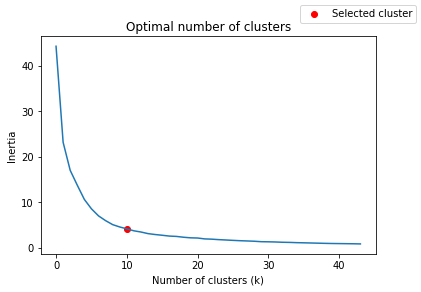

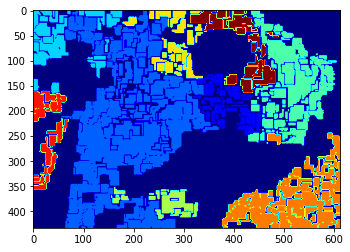

In [72]:
N_CLUSTERS = 10
im_regs = image_flat.copy()

image_norm = list()
gray_values = list() # Gray values for the regions partitions

## CREATE ARRAY BEFORE NORMALIZATION
for center in centers[:]:
  gray_values.append(im_regs[int(center[0])][int(center[1])])

gray_values = (gray_values - min(gray_values)) / (max(gray_values) - min(gray_values))

for i,center in enumerate(centers[:]):
  x = center[0] / im_regs.shape[1]
  y = center[1] / im_regs.shape[0]
  z = gray_values[i]
  image_norm.append(np.array([x,y,z]))

image_norm_array = np.asarray(image_norm)
image_norm_array = np.float32(image_norm_array)

weights_list = list()

for n in image_norm_array[:]:
  weights_list.append(n[2] * 10)

weights = np.asarray(weights_list)

# TESTING KMEANS
wcss = list()
for i in range(1,int((len(centers) / 5))):
  kmeanstest = KMeans(n_clusters=i, random_state=0).fit(image_norm_array ) #, sample_weight=weights)
  wcss.append(kmeanstest.inertia_)

fig0, ax = plt.subplots(1,1)
ax.scatter(N_CLUSTERS,wcss[N_CLUSTERS], c='red', label="Selected cluster")
ax.plot( np.arange(len(wcss)) , wcss)
ax.set_title("Optimal number of clusters")
ax.set_xlabel("Number of clusters (k)")
ax.set_ylabel("Inertia")
fig0.legend()

clustering = KMeans(n_clusters=N_CLUSTERS, max_iter=500).fit(image_norm_array  ) #, sample_weight=weights)

cluster_centers = clustering.cluster_centers_
cluster_labels = clustering.labels_.flatten()

fig, ax = plt.subplots(1,1)
tmp = np.zeros(im_regs.shape, np.uint8)
for i,lbl in enumerate(cluster_labels[:]):
  tmp = np.where(labels_partition == (i + 1), lbl, tmp)
  ax.imshow(tmp,cmap="jet")

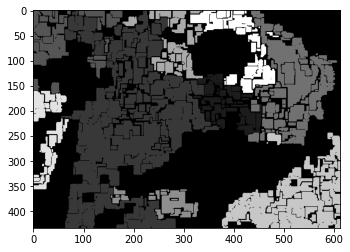

In [73]:
fig, ax = plt.subplots(1,1)

im_clusters = np.zeros(im_regs.shape, np.uint8)

for i,lbl in enumerate(cluster_labels[:]):
  im_clusters = np.where(labels_partition == (i + 1), lbl, im_clusters)
  ax.imshow(im_clusters,cmap="gray")

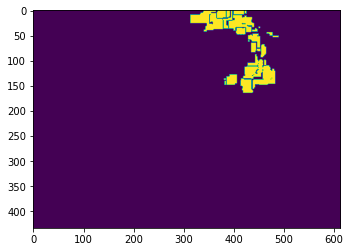

In [88]:
# SI YO LE DIGO DEME LOS PIXELES DEL CLUSTER 3 

tmp = np.zeros(im_regs.shape, np.uint8)
tmp = np.where(im_clusters == 9,1, tmp)
plt.imshow(tmp)

In [89]:
max(cluster_labels)

9

perc: true_positives 1 %
perc: false_positives 98 %
perc: false_negatives 99 %


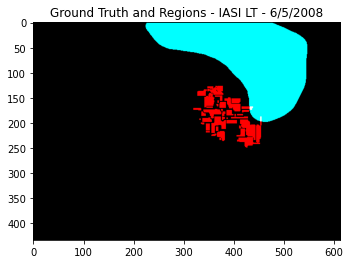

perc: true_positives 1 %
perc: false_positives 98 %
perc: false_negatives 98 %


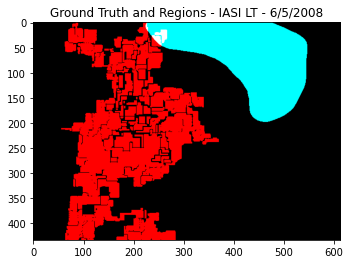

perc: true_positives 0 %
perc: false_positives 100 %
perc: false_negatives 100 %


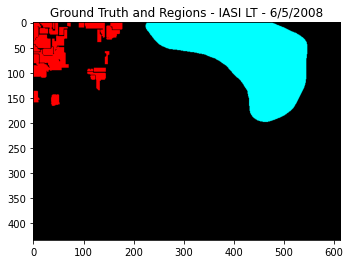

perc: true_positives 46 %
perc: false_positives 53 %
perc: false_negatives 72 %


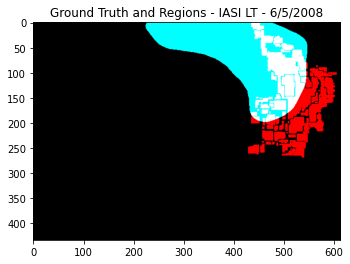

perc: true_positives 0 %
perc: false_positives 100 %
perc: false_negatives 100 %


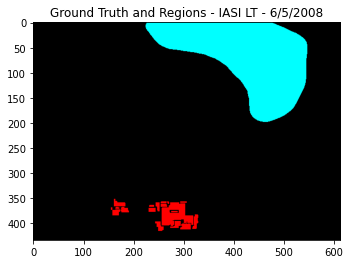

perc: true_positives 39 %
perc: false_positives 60 %
perc: false_negatives 92 %


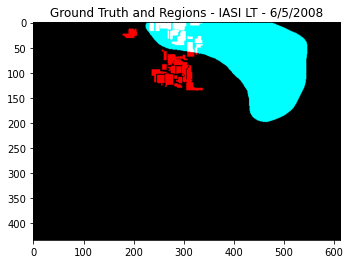

perc: true_positives 0 %
perc: false_positives 100 %
perc: false_negatives 100 %


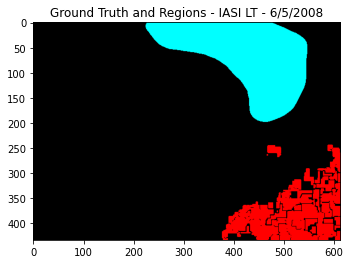

perc: true_positives 0 %
perc: false_positives 100 %
perc: false_negatives 100 %


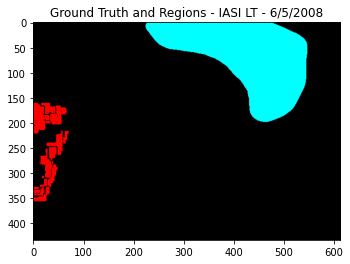

perc: true_positives 89 %
perc: false_positives 10 %
perc: false_negatives 78 %


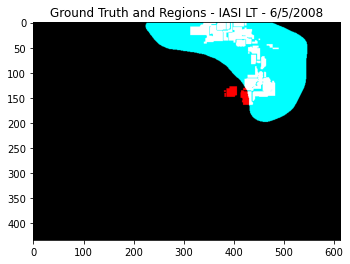

In [90]:
directories = os.listdir( imageLT.get_DIR_TRAIN() )
 
# This would print all the files and directories
for file in directories:
  only_png_files = re.search(".jpg", file)
  if only_png_files is not None:
    only_same_day = re.search(str(imageLT.get_year())+"%02d"%imageLT.get_month()+"%02d"%imageLT.get_day(), file)
    if only_same_day is not None:
      only_image_type = re.search(imageLT.get_image_type(), file)
      if only_image_type is not None:
        img = io.imread(imageLT.get_DIR_TRAIN() + file)
        #img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #img_gray = ma.masked_values(img_gray, 255.)
        img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

        best_regions_c = list()
        worst_regions_c = list()

        all_true_positives_c = list()
        all_true_negatives_c = list()
        all_false_positives_c = list()
        all_false_negatives_c = list()
        all_accuracy_c = list()

        for i in range(1,max(cluster_labels) + 1):
          im_bin = img_gray.copy()
          
          im_orig = np.zeros(im_regs.shape, np.uint8)
          im_orig = np.where(im_clusters == i,1, im_orig)

          im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          
          c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
          true_positives = c_m_temp[1][1]
          false_positives = c_m_temp[0][1]
          false_negatives = c_m_temp[1][0]
          true_negatives = c_m_temp[0][0]

          accuracy = accuracy_score(im_bin.flatten(),im_orig.flatten()) * 100
              
          #print("\n")
          total_pixels_blancs_ref = len(im_bin[im_bin == 1])
          total_pixels_blancs_test = len(im_orig[im_orig == 1])

          #im_test_ones = np.ones(im_bin.shape, np.uint8)
          #im_test_ones = np.where(im_bin == 1,0,im_test_ones)
          #im_test_ones = np.where(im_orig == 1,0,im_test_ones)
          #total_pixels_noirs = len(im_test_ones[im_test_ones == 1])

          #print("pixels: true_positives", true_positives)
          #print("pixels: false_positives",false_positives)
          #print("pixels: false_negatives",false_negatives)
          #print("pixels: true_negatives",true_negatives)
          #print("total_pixels_blancs_ref", total_pixels_blancs_ref)
          #print("total_pixels_blancs_test", total_pixels_blancs_test)
          
          print("perc: true_positives", int(true_positives * 100 / total_pixels_blancs_test), "%")
          print("perc: false_positives", int(false_positives * 100 / total_pixels_blancs_test), "%")
          print("perc: false_negatives", int(false_negatives * 100 / total_pixels_blancs_ref), "%")
          #print("perc: true_negatives", int(true_negatives * 100 / total_pixels_noirs), "%")

          all_true_positives_c.append(true_positives * 100 / total_pixels_blancs_test)
          all_false_positives_c.append(false_positives * 100 / total_pixels_blancs_test)
          all_false_negatives_c.append(false_negatives * 100 / total_pixels_blancs_ref)
          #all_true_negatives.append(true_negatives * 100 / total_pixels_noirs)
          all_accuracy_c.append(accuracy)

          if int(true_positives * 100 / total_pixels_blancs_test) >= 30:
            best_regions_c.append(im_orig)
          else:
            worst_regions_c.append(im_orig)

          #error = np.sum(np.abs(im_orig - im_bin))

          # visualize the differences between the original image and the solution
          plt.figure()
          plt.title('Ground Truth and Regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
          plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
          plt.show()

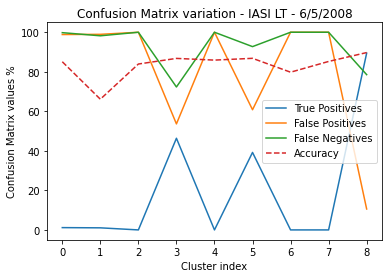

In [91]:
sensitivity_c = list()
for i,tp in enumerate(all_true_positives_c):
  sensitivity_c.append(tp / (tp + all_false_negatives_c[i]))

fig, ax = plt.subplots(1,1)
ax.plot( np.arange(len(all_true_positives_c)), all_true_positives_c, label="True Positives")
ax.plot( np.arange(len(all_false_positives_c)), all_false_positives_c, label="False Positives")
ax.plot( np.arange(len(all_false_negatives_c)), all_false_negatives_c, label="False Negatives")
ax.plot( np.arange(len(all_accuracy_c)), all_accuracy_c, "--", label="Accuracy")
#ax.plot( np.arange(len(sensitivity_c)), sensitivity_c, "--", label="Sensitivity")

ax.set_title('Confusion Matrix variation - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Confusion Matrix values %")
ax.legend()

Text(0.5, 1.0, 'Worst regions - IASI LT - 6/5/2008')

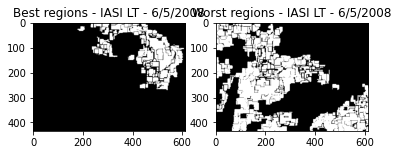

In [92]:
fig, (axx, axx2) = plt.subplots(1,2)

black_image_best = np.zeros(best_regions_c[0].shape, np.uint8)
black_image_worst = np.zeros(worst_regions_c[0].shape, np.uint8)

for reg in best_regions_c[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_best[i][j] = 1

for reg in worst_regions_c[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_worst[i][j] = 1


axx.imshow(black_image_best, cmap="gray")
axx.set_title('Best regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
axx2.imshow(black_image_worst, cmap="gray")
axx2.set_title('Worst regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )

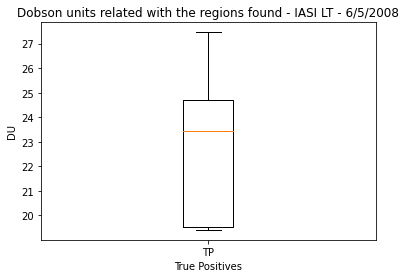

In [94]:
## COMPARING TRUE POSITIVES WITH GRAY VALUES AND POSITION IN SPACE

all_t_p_c = all_true_positives_c.copy()
all_f_p_c = all_false_positives_c.copy()
all_t_n_c = all_true_negatives_c.copy()
all_f_n_c = all_false_negatives_c.copy()

rx_test = regx.copy()
ry_test = regy.copy()
val_test = values.copy()

gray_levels_true_positive_c = list() # List of the best gray levels based on the true positives
for i,tp in enumerate(all_t_p_c):
  #if tp > 0:
  gray_levels_true_positive_c.append(val_test[i])


plt.boxplot([gray_levels_true_positive_c])
plt.title('Dobson units related with the regions found - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
plt.xlabel("True Positives")
plt.ylabel('DU')
ticks = range(1,2)
labels_plot = list(["TP"])
plt.xticks(ticks,labels_plot)
plt.show()


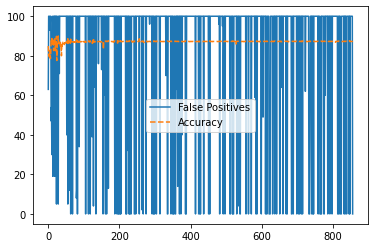

In [26]:
## THIS IS FOR COMPARE MSER REGIONS WITH THE GROUND TRUTH

im_bin = img_gray.copy()
mser_regions = regions.copy()
from sklearn.metrics import accuracy_score 

true_list_new = list()
pred_list_new = list()

all_true_positives = list()
all_true_negatives = list()
all_false_positives = list()
all_false_negatives = list()

all_accuracy = list()

for ii,region in enumerate(mser_regions[:]):
  try:
    img_mser = np.zeros(img_gray.shape, np.uint8)
    for k in region:
      cv2.circle(img_mser, (k[0],k[1]), radius=0, color=255, thickness=-1)
    im_orig = img_mser.copy()
    im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
    true_positives = c_m_temp[1][1]
    false_positives = c_m_temp[0][1]
    false_negatives = c_m_temp[1][0]
    true_negatives = c_m_temp[0][0]
    accuracy = accuracy_score(im_bin.flatten(),im_orig.flatten()) * 100
    total_pixels_blancs_test = len(im_orig[im_orig == 1])
    all_true_positives.append(int(true_positives * 100 / total_pixels_blancs_test))
    all_false_positives.append(int(false_positives * 100 / total_pixels_blancs_test))
    all_accuracy.append(accuracy)
    if int(true_positives * 100 / total_pixels_blancs_test) >= 30:
      best_regions.append(im_orig)
    else:
      worst_regions.append(im_orig)
  except:
    print("There was an error at region", ii)
  

fig, ax = plt.subplots(1,1)
#ax.plot( np.arange(len(all_true_positives)), all_true_positives, label="True Positives")
ax.plot( np.arange(len(all_false_positives)), all_false_positives, label="False Positives")
ax.plot( np.arange(len(all_accuracy)), all_accuracy, "--", label="Accuracy")
ax.legend()


  #true_list_new.append(im_bin)
  #pred_list_new.append(im_orig)

#true_list_new=np.array(true_list_new)
#pred_list_new=np.array(pred_list_new)

#true_list_new=true_list_new.flatten()
#pred_list_new=pred_list_new.flatten()

#c_m_mser = confusion_matrix(true_list_new, pred_list_new)
#a_s_mser = accuracy_score(true_list_new,pred_list_new) * 100

#print("Confusion Matrix: ", c_m_mser) 
#print("Accuracy : ", a_s_mser)

In [27]:
len(all_true_positives)

857

how_many_true_positive_regions 176 of 857


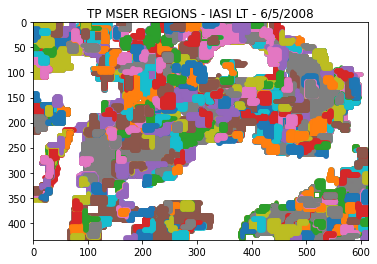

In [41]:
## COMPARING TRUE POSITIVES WITH GRAY VALUES AND POSITION IN SPACE

all_t_p = all_true_positives.copy()
all_f_p = all_false_positives.copy()

rx_test = regx.copy()
ry_test = regy.copy()
val_test = values.copy()
my_polys = polys.copy()

fig, ax = plt.subplots(1,1)
#fig1, ax1 = plt.subplots(1,1)
x_range = [0, image.shape[1]]
y_range = [0, image.shape[0]]

## FIG in 3D

#f3d = plt.figure(figsize=(14, 9))
#ax2 = plt.axes(projection ='3d')


# ax.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)

gray_levels_true_positive = list() # List of the best gray levels based on the true positives
how_many_true_positive_regions = 0
for i,tp in enumerate(all_t_p):  
  if tp > 0:
    gray_levels_true_positive.append(val_test[i])
    how_many_true_positive_regions += 1
  ax.scatter(rx_test[i], ry_test[i], marker='.',cmap="gray")
  ax.set_xlim(*x_range)
  ax.set_ylim(*y_range)
  ax.set_title('TP MSER REGIONS - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
  ax.invert_yaxis()
    #ax.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)

print("how_many_true_positive_regions", how_many_true_positive_regions, "of", len(val_test))

gray_leves_false_positive = list()

for i,fp in enumerate(all_f_p):
  #if fp < 100:
  gray_leves_false_positive.append(val_test[i])


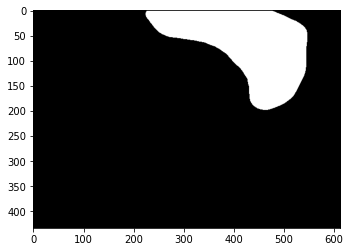

In [40]:
plt.imshow(im_bin, cmap="gray")

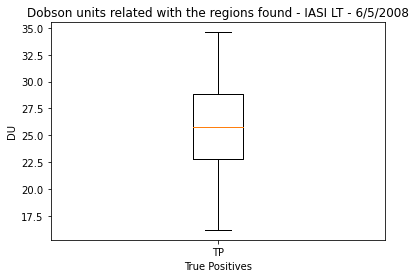

In [29]:
plt.boxplot([gray_levels_true_positive])
plt.title('Dobson units related with the regions found - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
plt.xlabel("True Positives")
plt.ylabel('DU')
ticks = range(1,2)
labels = list(["TP"])
plt.xticks(ticks,labels)
plt.show()

In [ ]:
image_regs_kms = image_flat.copy()

image_3 = image_flat.copy()
image_3 = cv2.normalize(image_3, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

image_norm = list()
for i,row in enumerate(image_3[:]):
  for j,col in enumerate(row[:]):
    _x = i / image_3.shape[1]
    _y = j / image_3.shape[0]
    _g = col
    image_norm.append(np.array([_g]))

image_norm_array = np.asarray(image_norm)
image_norm_array = np.float32(image_norm_array)

for i in image_norm_array[:10]:
  print(i)

image_regs_kms = ma.masked_values(image_regs_kms, 0.)
pixel_values = image_regs_kms.reshape((-1, 1))
pixel_values = np.float32(pixel_values)

print(pixel_values.shape,image_norm_array.shape )

[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
[0.71428573]
(266042, 1) (266042, 1)


[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
[194.13545]
(266042, 1) (320, 3)


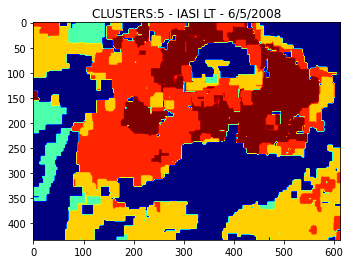

In [ ]:
#the below line of code defines the criteria for the algorithm to stop running, 
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
  
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initally chosed for k-means clustering
k = 5
retval, labels1, centers2 = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

retval11, labels11, centers11 = cv2.kmeans(image_norm_array, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)


#wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
#predicted_kmeans = kmeans.predict(X, sample_weight = Y)

# convert data into 8-bit values
#centers2 = np.uint8(centers2)
segmented_data = centers2[labels1.flatten()]
segmented_data_1 = centers11[labels11.flatten()]

for s in segmented_data[:10]:
  print(s)

print(segmented_data.shape, segmented_data_1.shape)

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image_regs_kms.shape))
segmented_image = segmented_image.astype(np.uint8)

#image_color = cv2.cvtColor(image_flat , cv2.COLOR_GRAY2RGB)
#segmented_image_2 = segmented_data_1.reshape(image_color.shape)

plt.imshow(segmented_image, cmap="jet")
plt.title('CLUSTERS:' +str(k)+ ' - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
plt.show()

To get the extracted regions I have to get the gray level predicted on the image created by kmeans

[99, 154, 194, 223]


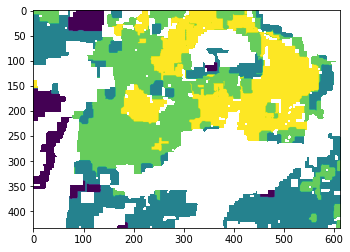

In [ ]:
s_i = segmented_image.copy()
s_i = ma.masked_values(s_i, 0.)

grays_level_predicted = list() # list of all gray levels needed as cluster

for i,val in enumerate(s_i):
  row = list(set(val.tolist())) # to get onique values from list
  for v in row:
    if v is not None and v not in grays_level_predicted:
      grays_level_predicted.append(v)

grays_level_predicted.sort()
print(grays_level_predicted)

#for cluster in grays_level_predicted[:len(grays_level_predicted) - 3]:
#  s_i[s_i == cluster] = 0
#s_i = ma.masked_values(s_i, 0.)

plt.imshow(s_i)

4 4


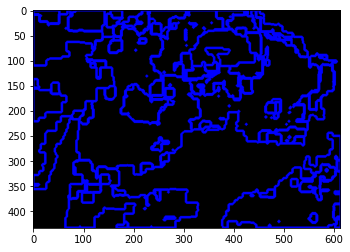

In [ ]:
c_i = s_i.copy()
g_l = grays_level_predicted.copy()

all_contours_regions = list()
all_content_regions = list()

for k in range(len(g_l)):
  tmp = c_i.copy()
  black = np.zeros(c_i.shape, np.uint8)
  for i in range(len(g_l)):
    if i is k:
      #black = np.where(tmp == g_l[i], 255, black) 
      #print(black.shape)
      black = np.where(tmp == g_l[i], 255, black) 
      #black[tmp == g_l[i]] = 1
    if i is not k:
      tmp[tmp == g_l[i]] = 0
  all_content_regions.append(black)
  tmp = ma.masked_values(tmp, 0.)
  contours, _ = cv2.findContours(tmp, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  all_contours_regions.append(contours)
  
fig3,ax3 = plt.subplots(1,1)
img_c = np.zeros(c_i.shape, np.uint8)
img_c = cv2.cvtColor(img_c, cv2.COLOR_GRAY2RGB)

print(len(all_contours_regions),len(all_content_regions))

for i, cont in enumerate(all_contours_regions):
  cv2.drawContours(img_c, cont, -1, (0,0,255), 3)
  ax3.imshow(img_c)

4


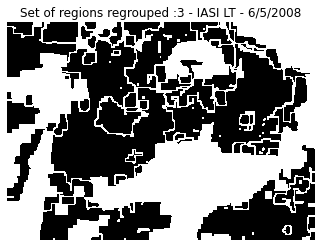

In [ ]:
f,x = plt.subplots(1,1)
print(len(all_content_regions))

for a in all_content_regions[:]:
  a = ma.masked_values(a, 0.)
  x.imshow(a, cmap="gray")
  x.axis('off')
  x.set_title('Set of regions regrouped :' +str(k)+ ' - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))

f.savefig(filename, bbox_inches='tight', pad_inches=0,transparent=True)
plt.close(fig)

In [ ]:
all_polys_regions = list()
all_points_regions = list()
for i,contours in enumerate(all_contours_regions[:]):
  polys_regions = list()
  points_regions = list()
  for contour in contours:
    if len(contour) > 2:
      myContour = list()
      for point in contour:
        myContour.append(point[0].tolist())
      polys_regions.append(Polygon(myContour))
      points_regions.append(MultiPoint(myContour))

  all_polys_regions.append(polys_regions)
  all_points_regions.append(points_regions)

print(len(all_polys_regions))

4


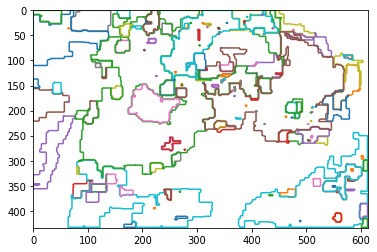

In [ ]:
fig, ax = plt.subplots(1,1)

xx_range = [0, c_i.shape[1]]
yy_range = [0, c_i.shape[0]]

for polys in all_polys_regions:
  for poly in polys:
    x,y = poly.exterior.xy

    ax.plot(x,y)
    ax.set_xlim(*xx_range)
    ax.set_ylim(*yy_range)
    ax.invert_yaxis()

In [ ]:
def print_confussion_matrix_results(cnf_matrix):
  FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
  FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
  TP = np.diag(cnf_matrix)
  TN = cnf_matrix.sum() - (FP + FN + TP)

  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP) 
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)

  print("TPR:",TPR,"PPV:",PPV,"NPV:",NPV,"FPR",FPR,"FNR",FNR,"FDR",FDR,"ACC",ACC)



perc: true_positives 0 %
perc: false_positives 100 %
perc: false_negatives 100 %


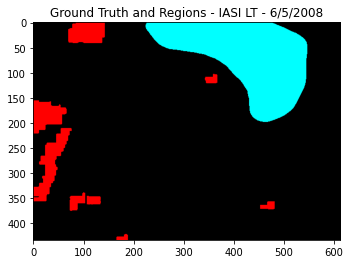



perc: true_positives 5 %
perc: false_positives 94 %
perc: false_negatives 91 %


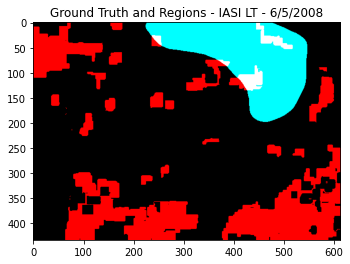



perc: true_positives 10 %
perc: false_positives 89 %
perc: false_negatives 80 %


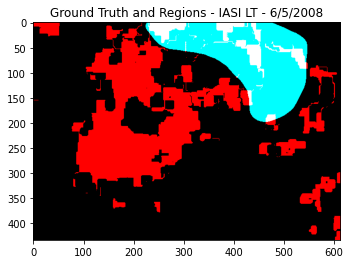



perc: true_positives 39 %
perc: false_positives 60 %
perc: false_negatives 49 %


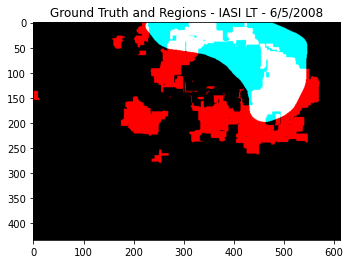

In [ ]:
directories = os.listdir( imageLT.get_DIR_TRAIN() )
 
# This would print all the files and directories
for file in directories:
  only_png_files = re.search(".jpg", file)
  if only_png_files is not None:
    only_same_day = re.search(str(imageLT.get_year())+"%02d"%imageLT.get_month()+"%02d"%imageLT.get_day(), file)
    if only_same_day is not None:
      only_image_type = re.search(imageLT.get_image_type(), file)
      if only_image_type is not None:
        img = io.imread(imageLT.get_DIR_TRAIN() + file)
        #img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #img_gray = ma.masked_values(img_gray, 255.)
        img_gray = cv2.GaussianBlur(img_gray,(5,5),cv2.BORDER_DEFAULT)

        best_regions = list()
        worst_regions = list()

        all_true_positives = list()
        all_true_negatives = list()
        all_false_positives = list()
        all_false_negatives = list()

        for region_ in all_content_regions:
          im_orig = region_.copy()
          im_bin = img_gray.copy()

          im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          
          c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
          true_positives = c_m_temp[1][1]
          false_positives = c_m_temp[0][1]
          false_negatives = c_m_temp[1][0]
          true_negatives = c_m_temp[0][0]
              
          #print("pixels: true_positives", true_positives)
          #print("pixels: false_positives",false_positives)
          #print("pixels: false_negatives",false_negatives)
          #print("pixels: true_negatives",true_negatives)
          print("\n")
          total_pixels_blancs_ref = len(im_bin[im_bin == 1])
          total_pixels_blancs_test = len(im_orig[im_orig == 1])
          #im_test_ones = np.ones(im_bin.shape, np.uint8)
          #im_test_ones = np.where(im_bin == 1,0,im_test_ones)
          #im_test_ones = np.where(im_orig == 1,0,im_test_ones)
          #total_pixels_noirs = len(im_test_ones[im_test_ones == 1])


          #print("total_pixels_blancs_ref", total_pixels_blancs_ref)
          #print("total_pixels_blancs_test", total_pixels_blancs_test)
          
          print("perc: true_positives", int(true_positives * 100 / total_pixels_blancs_test), "%")
          print("perc: false_positives", int(false_positives * 100 / total_pixels_blancs_test), "%")
          print("perc: false_negatives", int(false_negatives * 100 / total_pixels_blancs_ref), "%")
          #print("perc: true_negatives", int(true_negatives * 100 / total_pixels_noirs), "%")

          all_true_positives.append(true_positives * 100 / total_pixels_blancs_test)
          all_false_positives.append(false_positives * 100 / total_pixels_blancs_test)
          all_false_negatives.append(false_negatives * 100 / total_pixels_blancs_ref)
          #all_true_negatives.append(true_negatives * 100 / total_pixels_noirs)

          if int(true_positives * 100 / total_pixels_blancs_test) >= 30:
            best_regions.append(im_orig)
          else:
            worst_regions.append(im_orig)

          error = np.sum(np.abs(im_orig - im_bin))

          # visualize the differences between the original image and the solution
          plt.figure()
          plt.title('Ground Truth and Regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
          plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
          plt.show()

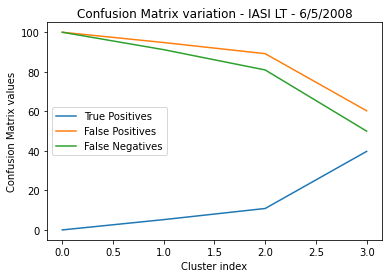

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot( np.arange(len(all_true_positives)), all_true_positives, label="True Positives")
ax.plot( np.arange(len(all_false_positives)), all_false_positives, label="False Positives")
ax.plot( np.arange(len(all_false_negatives)), all_false_negatives, label="False Negatives")
#ax.plot( np.arange(len(all_true_negatives)), all_true_negatives, label="True Negatives")

ax.set_title('Confusion Matrix variation - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Confusion Matrix values")
ax.legend()

Text(0.5, 1.0, 'Worst regions - IASI LT - 6/5/2008')

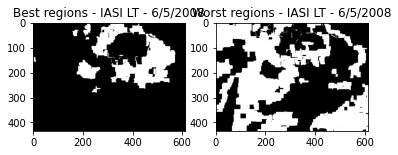

In [ ]:
fig, (axx, axx2) = plt.subplots(1,2)

black_image_best = np.zeros(best_regions[0].shape, np.uint8)
black_image_worst = np.zeros(worst_regions[0].shape, np.uint8)

for reg in best_regions[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_best[i][j] = 1

for reg in worst_regions[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_worst[i][j] = 1


axx.imshow(black_image_best, cmap="gray")
axx.set_title('Best regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
axx2.imshow(black_image_worst, cmap="gray")
axx2.set_title('Worst regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )

In [ ]:
## THIS IS FOR COMPARE MSER REGIONS WITH THE GROUND TRUTH

im_bin = img_gray.copy()
mser_regions = regions.copy()
from sklearn.metrics import accuracy_score 

true_list_new = list()
pred_list_new = list()

all_true_positives = list()
all_true_negatives = list()
all_false_positives = list()
all_false_negatives = list()

all_accuracy = list()

for region in mser_regions[:100]:
  img_mser = np.zeros(img_gray.shape, np.uint8)

  for k in region:
    cv2.circle(img_mser, (k[0],k[1]), radius=0, color=255, thickness=-1)

  im_orig = img_mser.copy()
  
  im_orig = cv2.normalize(im_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  im_bin = cv2.normalize(im_bin, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

  c_m_temp = confusion_matrix(im_bin.flatten(), im_orig.flatten())
  true_positives = c_m_temp[1][1]
  false_positives = c_m_temp[0][1]
  false_negatives = c_m_temp[1][0]
  true_negatives = c_m_temp[0][0]

  #accuracy = accuracy_score(im_bin.flatten(),im_orig.flatten()) * 100
  
  total_pixels_blancs_ref = len(im_bin[im_bin == 1])
  total_pixels_blancs_test = len(im_orig[im_orig == 1])
  im_test_ones = np.ones(im_bin.shape, np.uint8)
  im_test_ones = np.where(im_bin == 1,0,im_test_ones)
  im_test_ones = np.where(im_orig == 1,0,im_test_ones)

  total_pixels_noirs = len(im_test_ones[im_test_ones == 0])
  
  #print("\n")
  #print("perc: true_positives", int(true_positives * 100 / total_pixels_blancs_test), "%")
  #print("perc: false_positives", int(false_positives * 100 / total_pixels_blancs_test), "%")
  #print("perc: false_negatives", int(false_negatives * 100 / total_pixels_blancs_ref), "%")
  ##print("perc: true_negatives", int(true_negatives * 100 / total_pixels_noirs), "%")
  
  #plt.figure()
  #plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
  #plt.show()

  all_true_positives.append(int(true_positives * 100 / total_pixels_blancs_test))
  all_false_positives.append(int(false_positives * 100 / total_pixels_blancs_test))
  all_false_negatives.append(int(false_negatives * 100 / total_pixels_blancs_ref))
  all_true_negatives.append(int(true_negatives * 100 / total_pixels_noirs))
  #all_accuracy.append(accuracy)

  if int(true_positives * 100 / total_pixels_blancs_test) >= 30:
    best_regions.append(im_orig)
  else:
    worst_regions.append(im_orig)
  

#fig, ax = plt.subplots(1,1)
#ax.plot( np.arange(len(all_true_positives)), all_true_positives, label="True Positives")
#ax.plot( np.arange(len(all_false_positives)), all_false_positives, label="False Positives")
#ax.plot( np.arange(len(all_false_negatives)), all_false_negatives, label="False Negatives")
##ax.plot( np.arange(len(all_true_negatives)), all_true_negatives, label="True Negatives")
##ax.plot( np.arange(len(all_accuracy)), all_accuracy, "--", label="Accuracy")
#ax.legend()
  #true_list_new.append(im_bin)
  #pred_list_new.append(im_orig)

#true_list_new=np.array(true_list_new)
#pred_list_new=np.array(pred_list_new)

#true_list_new=true_list_new.flatten()
#pred_list_new=pred_list_new.flatten()

#c_m_mser = confusion_matrix(true_list_new, pred_list_new)
#a_s_mser = accuracy_score(true_list_new,pred_list_new) * 100

#print("Confusion Matrix: ", c_m_mser) 
#print("Accuracy : ", a_s_mser)

how_many_true_positive_regions 26 of 857


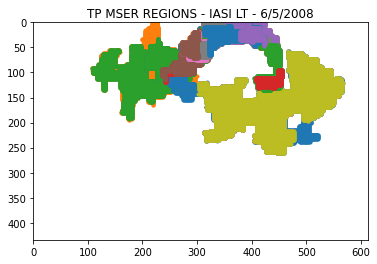

In [ ]:
## COMPARING TRUE POSITIVES WITH GRAY VALUES AND POSITION IN SPACE

all_t_p = all_true_positives.copy()
all_f_p = all_false_positives.copy()
all_t_n = all_true_negatives.copy()
all_f_n = all_false_negatives.copy()

rx_test = regx.copy()
ry_test = regy.copy()
val_test = values.copy()
my_polys = polys.copy()

fig, ax = plt.subplots(1,1)
#fig1, ax1 = plt.subplots(1,1)
x_range = [0, image.shape[1]]
y_range = [0, image.shape[0]]

## FIG in 3D

#f3d = plt.figure(figsize=(14, 9))
#ax2 = plt.axes(projection ='3d')

gray_levels_true_positive = list() # List of the best gray levels based on the true positives
how_many_true_positive_regions = 0
for i,tp in enumerate(all_t_p):
  if tp > 0:
    gray_levels_true_positive.append(val_test[i])
    how_many_true_positive_regions += 1
    ax.scatter(rx_test[i], ry_test[i], marker='.' )
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.set_title('TP MSER REGIONS - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
    ax.invert_yaxis()

print("how_many_true_positive_regions", how_many_true_positive_regions, "of", len(val_test))


gray_leves_false_positive = list()

for i,fp in enumerate(all_f_p):
  #if fp < 100:
  gray_leves_false_positive.append(val_test[i])
 

gray_leves_true_negative = list()

#for i,tn in enumerate(all_t_n):
#  #if tn > 0:
#  gray_leves_true_negative.append(val_test[i])


gray_leves_false_negative = list()

for i,fn in enumerate(all_f_n):
  #if fn < 100:
  gray_leves_false_negative.append(val_test[i])


    
    #ax2.scatter(rx_test[i], ry_test[i], val_test[i], marker='.')
    #ax2.set_title('BEST MSER REGIONS - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
  #print(tp, val_test[i], my_polys[i].centroid)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


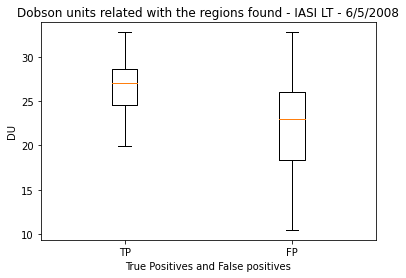

In [ ]:
plt.boxplot([gray_levels_true_positive, gray_leves_false_positive])
plt.title('Dobson units related with the regions found - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year))
plt.xlabel("True Positives and False positives")
plt.ylabel('DU')
ticks = range(1,3)
labels = list(["TP", "FP"])
plt.xticks(ticks,labels)
plt.show()

Text(0.5, 1.0, 'Worst regions - IASI LT - 6/5/2008')

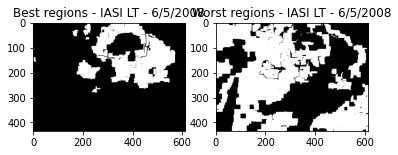

In [ ]:
fig, (axx, axx2) = plt.subplots(1,2)

black_image_best = np.zeros(best_regions[0].shape, np.uint8)
black_image_worst = np.zeros(worst_regions[0].shape, np.uint8)

for reg in best_regions[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_best[i][j] = 1

for reg in worst_regions[:]:
  tmp = ma.masked_values(reg, 0.)
  for i,x in enumerate(tmp[:]):
    for j,y in enumerate(x):
      if isinstance(y, np.uint8):
        black_image_worst[i][j] = 1


axx.imshow(black_image_best, cmap="gray")
axx.set_title('Best regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )
axx2.imshow(black_image_worst, cmap="gray")
axx2.set_title('Worst regions - IASI ' + imageLT.image_type + " - " + str(imageLT.day) +"/"+ str(imageLT.month) +"/"+ str(imageLT.year) )